<a href="https://colab.research.google.com/github/HarryJ12/AI-Powered_NFL_Team_Performance_Predictor/blob/main/Model_Training_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
import io

uploaded = files.upload()
for filename in uploaded.keys():
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))
    print(f"DataFrame from {filename}:")
    display(df.head())

Saving theOne.csv to theOne (2).csv
DataFrame from theOne (2).csv:


,season,week,month,team,opponent,location,win_numeric,score_for,score_against,first_downs,...,turnovers_forced,turnovers_commited,turnover_diff_pct,def_st_td,possession_time,redzone_efficiency,third_down_efficiency,yards_per_play,rush_yards_per_attempt,pass_completion_pct
0,2022,1,9,Bills,Rams,0,1,31,10,23,...,3,4,-1,0,31,100.0,90.0,7.1,4.8,83.9
1,2022,1,9,Rams,Bills,1,0,10,31,19,...,4,3,1,0,29,50.0,46.2,3.7,2.9,70.7
2,2022,1,9,Browns,Panthers,0,1,26,24,23,...,1,0,1,0,38,25.0,44.4,4.8,5.6,52.9
3,2022,1,9,Panthers,Browns,1,0,24,26,15,...,0,1,-1,0,22,66.7,36.4,5.2,2.8,59.3
4,2022,1,9,Jaguars,Commanders,0,0,22,28,24,...,3,1,2,0,27,40.0,25.0,6.2,6.8,57.1


Linear Regression RMSE: 4.349027838123368
Linear Regression R²: 0.8047872752472223
Random Forest RMSE: 4.367455903245246
Random Forest R²: 0.8031294268610362
XGBoost RMSE: 4.358087383694928
XGBoost R²: 0.8039731383323669


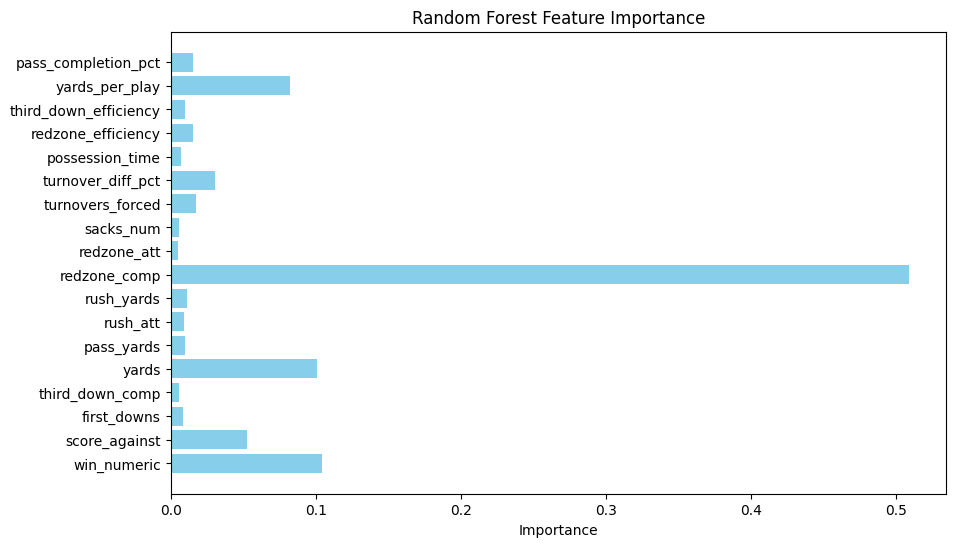

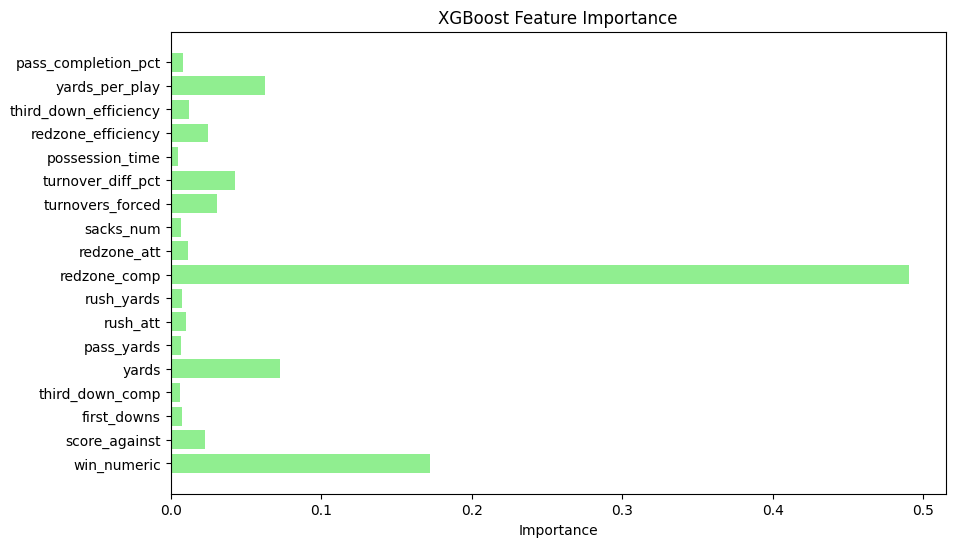

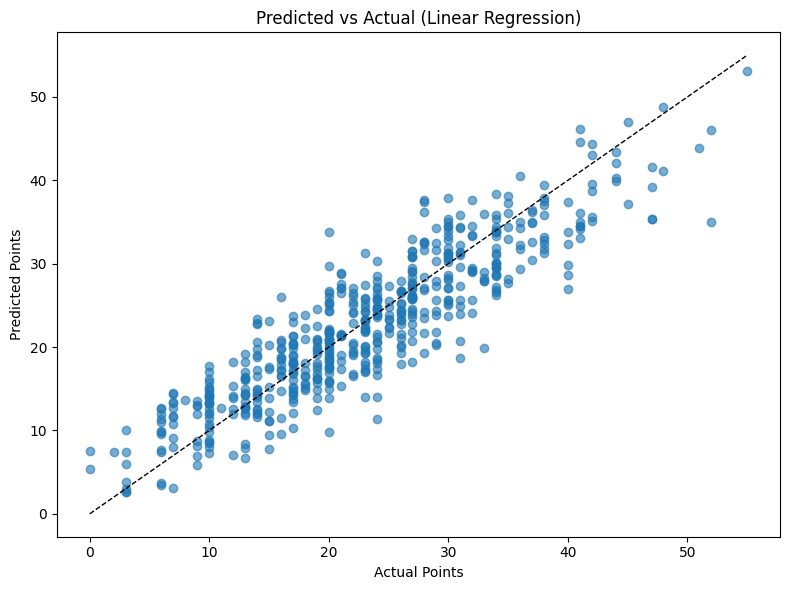

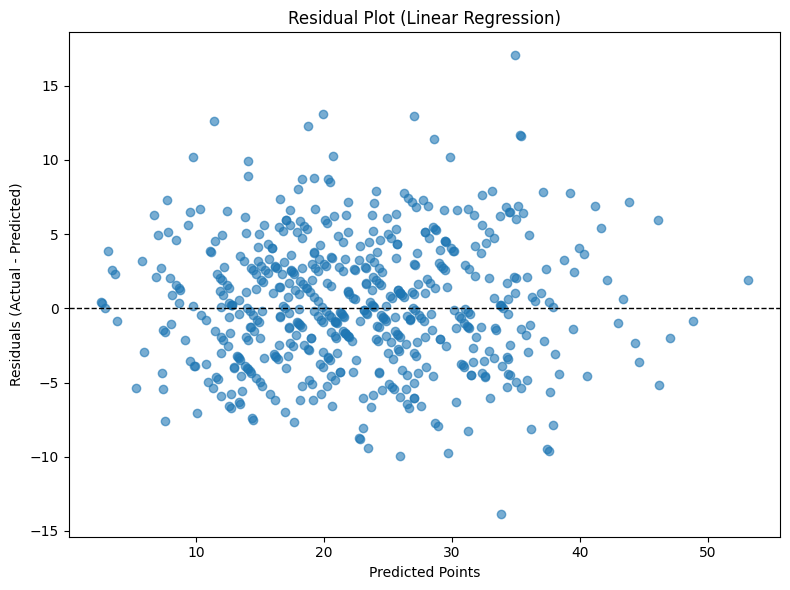

In [ ]:
# Data Prep
selected_features = [
    "win_numeric",
    "score_against",
    "first_downs",
    "third_down_comp",
    "yards",
    "pass_yards",
    "rush_att",
    "rush_yards",
    "redzone_comp",
    "redzone_att",
    "sacks_num",
    "turnovers_forced",
    "turnover_diff_pct",
    "possession_time",
    "redzone_efficiency",
    "third_down_efficiency",
    "yards_per_play",
    "pass_completion_pct",
]
regression_target = "score_for"

# Split train/test
train_df = df[df["season"].isin([2022, 2023])]
test_df = df[df["season"] == 2024]
X_train = train_df[selected_features].copy()
X_test = test_df[selected_features].copy()
y_train = train_df[regression_target].copy()
y_test = test_df[regression_target].copy()


# Since possession_time is in "MM:SS" format, convert to seconds
if X_train['possession_time'].dtype == object:
    def time_to_seconds(t):
        try:
            m, s = map(int, t.split(':'))
            return m*60 + s
        except:
            return 0
    X_train['possession_time'] = X_train['possession_time'].apply(time_to_seconds)
    X_test['possession_time'] = X_test['possession_time'].apply(time_to_seconds)


# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = np.clip(y_pred_lr, 0, None)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))

# Random Forest Regressor & Importance Plot
rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
plt.figure(figsize=(10,6))
importances_rf = rf.feature_importances_
plt.barh(selected_features, importances_rf, color='skyblue')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

# XGBoost Regressor & Importance Plot
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
plt.figure(figsize=(10,6))
importances_xgb = xgb.feature_importances_
plt.barh(selected_features, importances_xgb, color='lightgreen')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()
plt.figure(figsize=(8, 6))

# Scatter points
plt.scatter(y_test, y_pred_lr, alpha=0.6)
min_v = min(y_test.min(), y_pred_lr.min())
max_v = max(y_test.max(), y_pred_lr.max())
plt.plot([min_v, max_v], [min_v, max_v], "k--", linewidth=1)
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Predicted vs Actual (Linear Regression)")
plt.tight_layout()
plt.show()

# Residual Plot (Linear Regression)
residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Predicted Points")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Linear Regression)")
plt.tight_layout()
plt.show()

In [ ]:
# TEST
team_to_predict = "Rams"
season_to_predict = 2024
team_games = df[(df["team"] == team_to_predict) & (df["season"] == season_to_predict)]
features_for_prediction = [f for f in selected_features if f in team_games.columns]
team_games_numeric = team_games[features_for_prediction].apply(pd.to_numeric, errors='coerce').fillna(0)
X_input = pd.DataFrame([team_games_numeric.mean().values], columns=features_for_prediction)
pred_lr = np.clip(lr.predict(X_input), 0, None)
pred_rf = rf.predict(X_input)
pred_xgb = xgb.predict(X_input)

print("Predicted Bills score:")
print(f"Linear Regression: {pred_lr[0]:.1f}")
print(f"Random Forest: {pred_rf[0]:.1f}")
print(f"XGBoost: {pred_xgb[0]:.1f}")

Predicted Bills score:
Linear Regression: 23.3
Random Forest: 25.0
XGBoost: 16.2


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
from google.colab import files
import io

uploaded = files.upload()
for filename in uploaded.keys():
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))
    print(f"DataFrame from {filename}:")
    display(df.head())

Saving theOne.csv to theOne (1).csv
DataFrame from theOne (1).csv:


,season,week,month,team,opponent,location,win_numeric,score_for,score_against,first_downs,...,turnovers_forced,turnovers_commited,turnover_diff_pct,def_st_td,possession_time,redzone_efficiency,third_down_efficiency,yards_per_play,rush_yards_per_attempt,pass_completion_pct
0,2022,1,9,Bills,Rams,0,1,31,10,23,...,3,4,-1,0,31,100.0,90.0,7.1,4.8,83.9
1,2022,1,9,Rams,Bills,1,0,10,31,19,...,4,3,1,0,29,50.0,46.2,3.7,2.9,70.7
2,2022,1,9,Browns,Panthers,0,1,26,24,23,...,1,0,1,0,38,25.0,44.4,4.8,5.6,52.9
3,2022,1,9,Panthers,Browns,1,0,24,26,15,...,0,1,-1,0,22,66.7,36.4,5.2,2.8,59.3
4,2022,1,9,Jaguars,Commanders,0,0,22,28,24,...,3,1,2,0,27,40.0,25.0,6.2,6.8,57.1



===== ORIGINAL LOGISTIC MODEL METRICS =====
Accuracy: 0.7982456140350878
F1 Score: 0.7985989492119089
Brier Score: 0.13864144000973638
ROC-AUC: 0.8837426900584795

===== XGBOOST MODEL METRICS =====
Accuracy: 0.7666666666666667
F1 Score: 0.7734241908006815
Brier Score: 0.16371649811160763
ROC-AUC: 0.8535426285010773


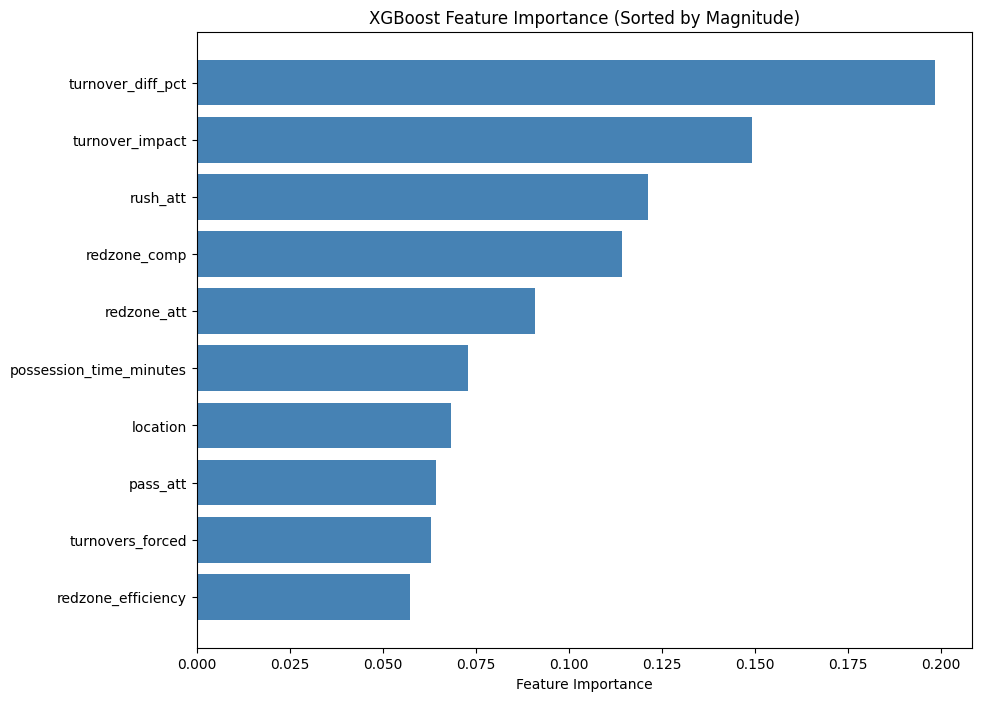

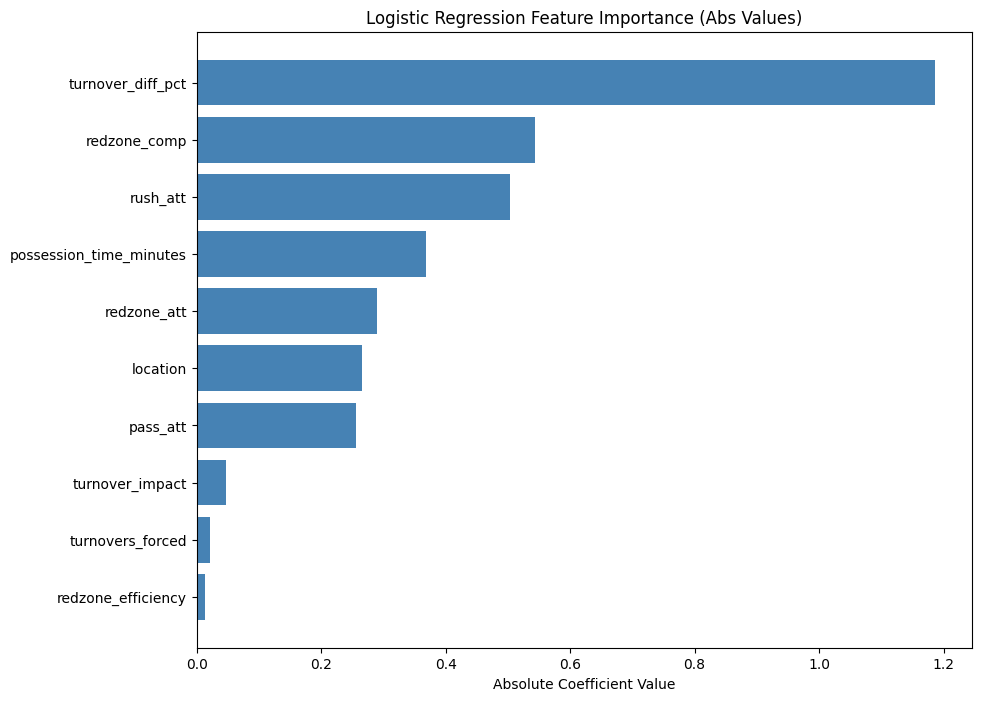

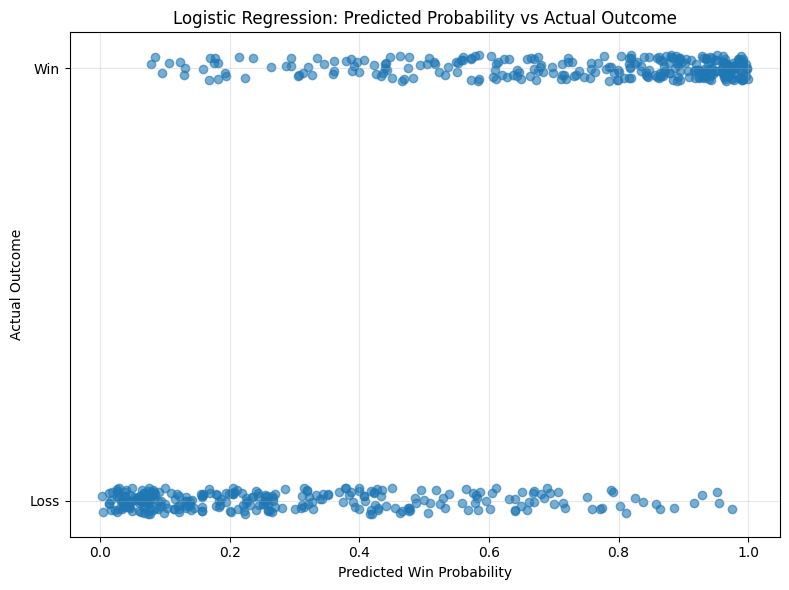

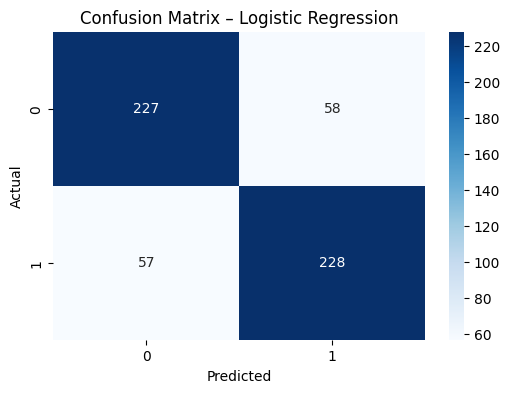

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Data Prep (Classification)
if df["possession_time"].dtype == object:
    df["possession_time_minutes"] = (
        df["possession_time"]
        .str.split(":", expand=True)
        .astype(int)
        .apply(lambda x: x[0] + x[1] / 60, axis=1)
    )
else:
    df["possession_time_minutes"] = df["possession_time"]

df["redzone_efficiency"] = df["redzone_comp"] / df["redzone_att"].clip(lower=1)
df["turnover_impact"] = df["turnover_diff_pct"] * df["possession_time_minutes"]
features = [
    "turnovers_forced", "turnover_diff_pct",
    "redzone_comp", "redzone_att", "possession_time_minutes",
    "pass_att", "rush_att", "location",
    "redzone_efficiency", "turnover_impact"
]

target = "win_numeric"

# TRAIN / TEST SPLIT
train_df = df[df["season"].isin([2022, 2023])]
test_df  = df[df["season"] == 2024]
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# SCALE (ONLY FOR LOGISTIC REGRESSION)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# LOGISTIC REGRESSION
lr2 = LogisticRegression(max_iter=5000, class_weight="balanced")
lr2.fit(X_train_scaled, y_train)
preds_lr2 = lr2.predict(X_test_scaled)
acc_lr2 = accuracy_score(y_test, preds_lr2)
f1_lr2 = f1_score(y_test, preds_lr2)

# XGBOOST
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)
preds_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, preds_xgb)
f1_xgb = f1_score(y_test, preds_xgb)

# LOGISTIC MODEL METRICS

logi_proba = lr2.predict_proba(X_test_scaled)[:, 1]
logi_preds = (logi_proba >= 0.5).astype(int)
print("\n===== LOGISTIC MODEL METRICS =====")
print("Accuracy:", accuracy_score(y_test, logi_preds))
print("F1 Score:", f1_score(y_test, logi_preds))
print("Brier Score:", brier_score_loss(y_test, logi_proba))
print("ROC-AUC:", roc_auc_score(y_test, logi_proba))


# XGBOOST MODEL METRICS
xgb_proba = xgb.predict_proba(X_test)[:, 1]
roc_xgb   = roc_auc_score(y_test, xgb_proba)
brier_xgb = brier_score_loss(y_test, xgb_proba)
print("\n===== XGBOOST MODEL METRICS =====")
print("Accuracy:", acc_xgb)
print("F1 Score:", f1_xgb)
print("Brier Score:", brier_xgb)
print("ROC-AUC:", roc_xgb)

# XGBOOST FEATURE IMPORTANCE PLOT
importances = xgb.feature_importances_
indices = np.argsort(np.abs(importances))
plt.figure(figsize=(10,8))
plt.barh(range(len(indices)), importances[indices], align="center", color="steelblue")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (Sorted by Magnitude)")
plt.show()

# LOGISTIC REGRESSION FEATURE IMPORTANCE PLOT
coefs = lr2.coef_[0]
indices_lr2 = np.argsort(np.abs(coefs))
plt.figure(figsize=(10,8))
plt.barh(
    range(len(indices_lr2)),
    np.abs(coefs[indices_lr2]),
    align="center",
    color="steelblue"
)
plt.yticks(range(len(indices_lr2)), [features[i] for i in indices_lr2])
plt.xlabel("Absolute Coefficient Value")
plt.title("Logistic Regression Feature Importance (Abs Values)")
plt.show()

# Logistic Regression JITTER PLOT
y_test_log = y_test.values
y_prob_log = lr2.predict_proba(X_test_scaled)[:, 1]
plt.figure(figsize=(8, 6))
jitter = np.random.uniform(-0.03, 0.03, size=len(y_test_log))
plt.scatter(y_prob_log, y_test_log + jitter, alpha=0.6)
plt.yticks([0, 1], ["Loss", "Win"])
plt.xlabel("Predicted Win Probability")
plt.ylabel("Actual Outcome")
plt.title("Logistic Regression: Predicted Probability vs Actual Outcome")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# CONFUSION MATRIX - LOGI
logi_pred_class = (logi_proba >= 0.5).astype(int)
cm_logi = confusion_matrix(y_test, logi_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(cm_logi, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

In [ ]:
# TESTER

def predict_future_game(team1, team2, df, features, lr2, xgb, scaler):
    team1_avg = df[df["team"] == team1][features].mean()
    team2_avg = df[df["team"] == team2][features].mean()
    team1_scaled = scaler.transform(pd.DataFrame([team1_avg], columns=features))
    team2_scaled = scaler.transform(pd.DataFrame([team2_avg], columns=features))
    feature_vector_scaled = team1_scaled - team2_scaled
    pred_lr_prob = lr2.predict_proba(feature_vector_scaled)[0,1]
    pred_xgb_prob = xgb.predict_proba(feature_vector_scaled)[0,1]
    pred_lr = 1 if pred_lr_prob >= 0.5 else 0
    pred_xgb = 1 if pred_xgb_prob >= 0.5 else 0

    return {
        "Logistic Regression": {"team1_win_prob": pred_lr_prob, "team2_win_prob": 1 - pred_lr_prob, "prediction": pred_lr},
        "XGBoost": {"team1_win_prob": pred_xgb_prob, "team2_win_prob": 1 - pred_xgb_prob, "prediction": pred_xgb}
    }

team1 = "Chiefs"
team2 = "Cowboys"

results = predict_future_game(team1, team2, df, features, lr2, xgb, scaler)
for model, info in results.items():
    print(f"{model} predicts: {'Win' if info['prediction']==1 else 'Loss'} for {team1} vs {team2}")
    print(f"Team1 win probability: {info['team1_win_prob']:.2f}, Team2 win probability: {info['team2_win_prob']:.2f}\n")


Logistic Regression predicts: Loss for Chiefs vs Cowboys
Team1 win probability: 0.46, Team2 win probability: 0.54

XGBoost predicts: Loss for Chiefs vs Cowboys
Team1 win probability: 0.01, Team2 win probability: 0.99



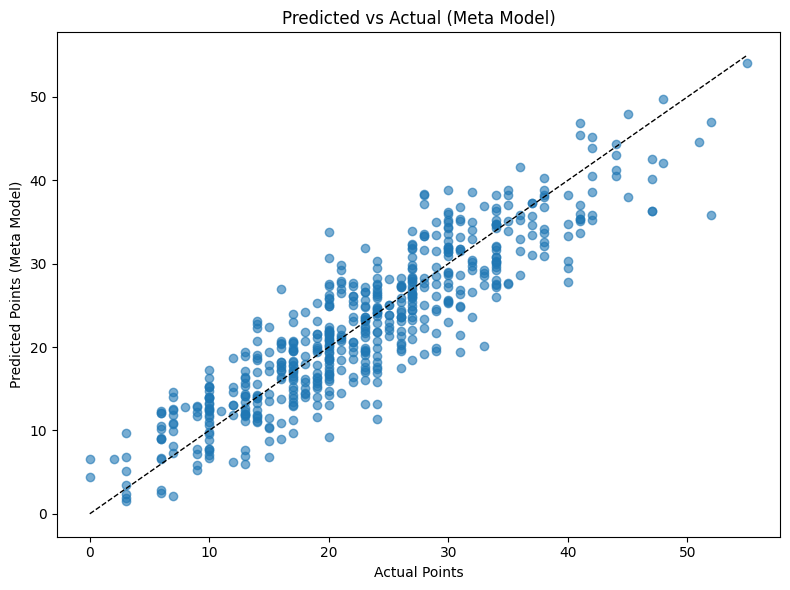

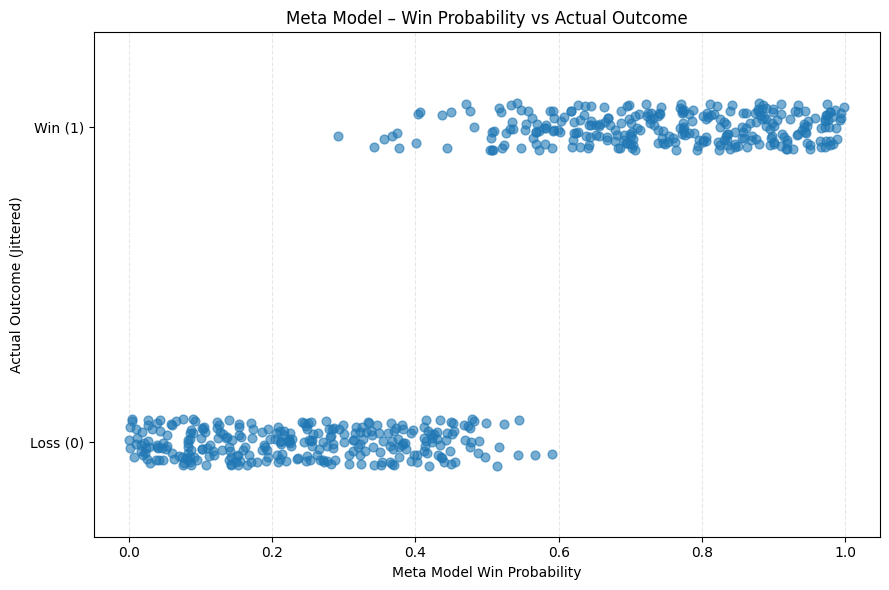

In [ ]:
# MTEA MODEL BUILD

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from scipy.stats import norm

# DATA PREP (SHARED)
df = df.copy()
def time_to_minutes(t):
    try:
        m, s = map(int, t.split(":"))
        return m + s/60
    except:
        return 0

df["possession_time_min"] = df["possession_time"].apply(time_to_minutes)
df["redzone_efficiency"] = df["redzone_comp"] / df["redzone_att"].clip(lower=1)
df["turnover_impact"]   = df["turnover_diff_pct"] * df["possession_time_min"]

# TRAIN SCORE MODEL (REGRESSION AGAIN)
reg_features = [
    "win_numeric", "score_against", "first_downs", "third_down_comp",
    "yards", "pass_yards", "rush_att", "rush_yards", "redzone_comp",
    "redzone_att", "sacks_num", "turnovers_forced", "turnover_diff_pct",
    "possession_time_min", "redzone_efficiency", "third_down_efficiency",
    "yards_per_play", "pass_completion_pct"
]

train_df = df[df["season"].isin([2022, 2023])]
test_df  = df[df["season"] == 2024]
X_reg_train = train_df[reg_features].apply(pd.to_numeric, errors="coerce").fillna(0)
X_reg_test  = test_df[reg_features].apply(pd.to_numeric, errors="coerce").fillna(0)
y_reg_train = train_df["score_for"]
y_reg_test  = test_df["score_for"]
reg = LinearRegression()
reg.fit(X_reg_train, y_reg_train)
test_reg_pred = np.clip(reg.predict(X_reg_test), 0, None)

# TRAIN WIN/LOSS MODEL (LOGISTIC AGAIN)
clf_features = [
    "turnovers_forced", "turnover_diff_pct",
    "redzone_comp", "redzone_att", "possession_time_min",
    "pass_att", "rush_att", "location",
    "redzone_efficiency", "turnover_impact"
]

X_clf_train = train_df[clf_features]
X_clf_test  = test_df[clf_features]
y_clf_train = train_df["win_numeric"]
y_clf_test  = test_df["win_numeric"]
scaler = StandardScaler()
X_clf_train_s = scaler.fit_transform(X_clf_train)
X_clf_test_s  = scaler.transform(X_clf_test)
clf = LogisticRegression(max_iter=5000, class_weight="balanced")
clf.fit(X_clf_train_s, y_clf_train)
test_clf_proba = clf.predict_proba(X_clf_test_s)[:, 1]  # P(win)

# BETTING-MARKET META LAYER
def vegas_meta(score_pred, win_prob):
    bias = (win_prob - 0.5) * 2   # win_prob=1 → +1 point, win_prob=0 → -1 point
    return float(np.clip(score_pred + bias, 0, None))
meta_scores = [
    vegas_meta(score, prob)
    for score, prob in zip(test_reg_pred, test_clf_proba)
]

# META MODEL SCATTER PLOT (SCORE)
meta_scores = np.array(meta_scores)
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, meta_scores, alpha=0.6)

min_v = min(y_reg_test.min(), meta_scores.min())
max_v = max(y_reg_test.max(), meta_scores.max())
plt.plot([min_v, max_v], [min_v, max_v], "k--", linewidth=1)

plt.xlabel("Actual Points")
plt.ylabel("Predicted Points (Meta Model)")
plt.title("Predicted vs Actual (Meta Model)")
plt.tight_layout()
plt.show()

# META MODEL JITTER PLOT (WIN PROB)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

meta_margin = meta_scores - test_df["score_against"].values
meta_win_prob = norm.cdf(meta_margin / 13.86)
actual = y_clf_test.values  # 0 = loss, 1 = win
jitter = (np.random.rand(len(actual)) - 0.5) * 0.15
y_jittered = actual + jitter
plt.figure(figsize=(9, 6))
plt.scatter(meta_win_prob, y_jittered, alpha=0.6, s=40)

plt.yticks([0, 1], ["Loss (0)", "Win (1)"])
plt.xlabel("Meta Model Win Probability")
plt.ylabel("Actual Outcome (Jittered)")
plt.title("Meta Model – Win Probability vs Actual Outcome")

plt.ylim(-0.3, 1.3)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# TESTER

def predict_matchup(team1, team2):
    t1_games = df[df["team"] == team1]
    t2_games = df[df["team"] == team2]

    if t1_games.empty or t2_games.empty:
        raise ValueError("Team data missing for one of the teams.")

    # REGRESSION INPUTS
    t1_reg = t1_games[reg_features].apply(pd.to_numeric, errors="coerce").fillna(0).mean().to_frame().T
    t2_reg = t2_games[reg_features].apply(pd.to_numeric, errors="coerce").fillna(0).mean().to_frame().T

    t1_score_raw = float(np.clip(reg.predict(t1_reg)[0], 0, None))
    t2_score_raw = float(np.clip(reg.predict(t2_reg)[0], 0, None))

    # CLASSIFIER INPUTS
    t1_clf_df = t1_games[clf_features].apply(pd.to_numeric, errors="coerce").fillna(0).mean().to_frame().T
    t2_clf_df = t2_games[clf_features].apply(pd.to_numeric, errors="coerce").fillna(0).mean().to_frame().T

    t1_win_raw = clf.predict_proba(scaler.transform(t1_clf_df))[0, 1]
    t2_win_raw = clf.predict_proba(scaler.transform(t2_clf_df))[0, 1]

    # META-ADJUSTED SCORES
    t1_score = vegas_meta(t1_score_raw, t1_win_raw)
    t2_score = vegas_meta(t2_score_raw, t2_win_raw)

    # VEGAS SPREAD → WIN PROBABILITY
    spread = t1_score - t2_score
    t1_prob = float(norm.cdf(spread / 13.86))
    t2_prob = 1 - t1_prob

    return {
        "matchup": f"{team1} vs {team2}",
        "predicted_scores": {
            team1: round(t1_score, 1),
            team2: round(t2_score, 1)
        },
        "win_probabilities": {
            team1: f"{round(t1_prob * 100):02d}%",
            team2: f"{round(t2_prob * 100):02d}%"
        }
    }

In [ ]:
predict_matchup("Jets", "Seahawks")

{'matchup': 'Jets vs Seahawks',
 'predicted_scores': {'Jets': 16.5, 'Seahawks': 21.3},
 'win_probabilities': {'Jets': '37%', 'Seahawks': '63%'}}

In [ ]:
# META MODEL METRICS

meta_scores = np.array(meta_scores)
rmse_meta = np.sqrt(mean_squared_error(y_reg_test, meta_scores))
r2_meta   = r2_score(y_reg_test, meta_scores)

print("=== META-MODEL METRICS ===")
print(f"RMSE: {rmse_meta:.3f}")
print(f"R²  : {r2_meta:.3f}")
print()

=== META-MODEL METRICS ===
RMSE: 4.403
R²  : 0.800



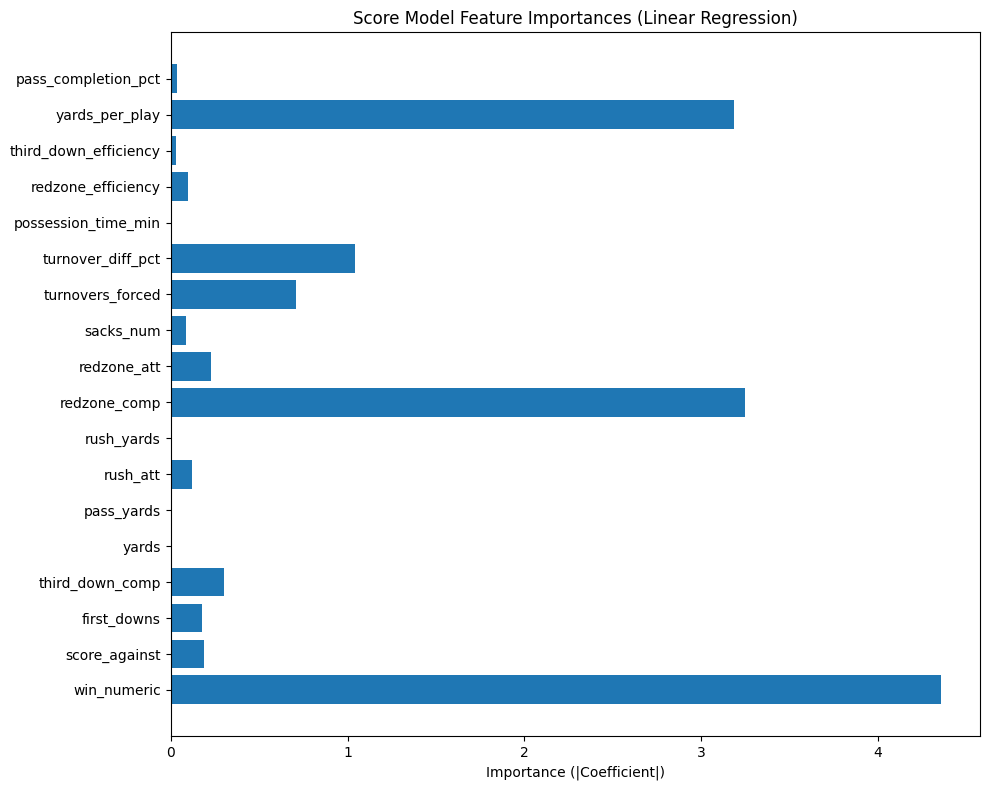

In [ ]:
# REGRESSION FEATURE IMPORTANCE

import matplotlib.pyplot as plt
import numpy as np

reg_importance = np.abs(reg.coef_)
plt.figure(figsize=(10, 8))
plt.barh(reg_features, reg_importance)
plt.xlabel("Importance (|Coefficient|)")
plt.title("Score Model Feature Importances (Linear Regression)")
plt.tight_layout()
plt.show()

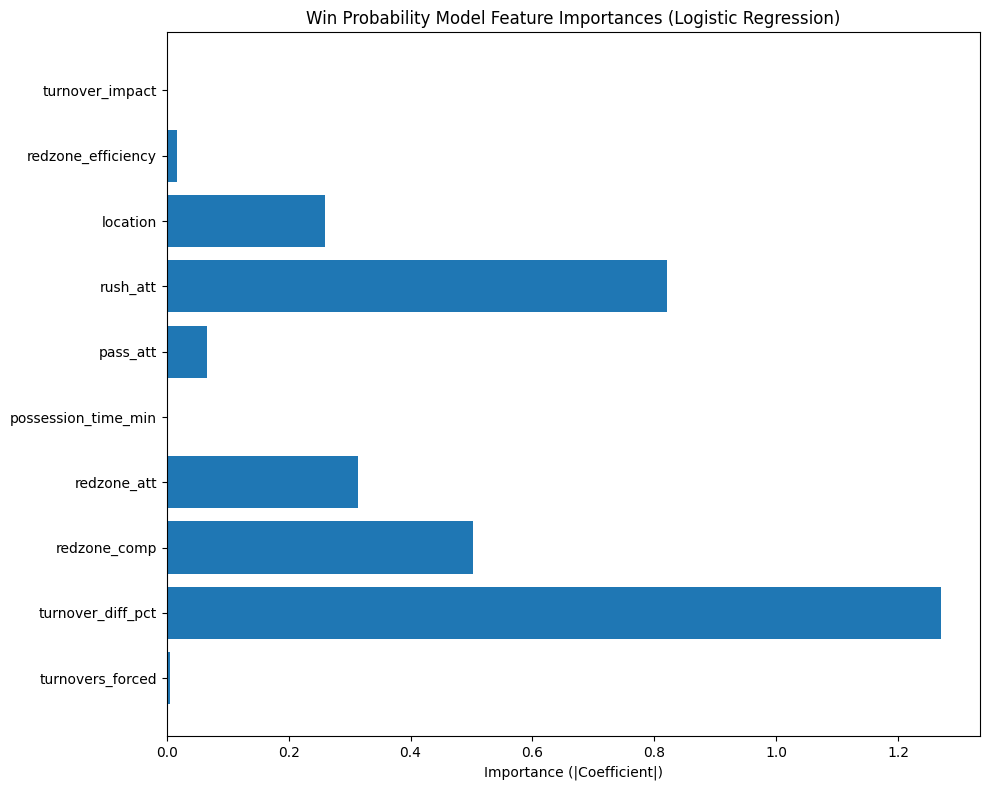

In [ ]:
# LOGISTIC FEATURE IMPORTANCE

clf_importance = np.abs(clf.coef_[0])
plt.figure(figsize=(10, 8))
plt.barh(clf_features, clf_importance)
plt.xlabel("Importance (|Coefficient|)")
plt.title("Win Probability Model Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import numpy as np

class MetaModel:
    def __init__(self, reg_model, clf_model, scaler):
        self.reg = reg_model
        self.clf = clf_model
        self.scaler = scaler

    def vegas_meta(self, score_pred, win_prob):
        bias = (win_prob - 0.5) * 2
        return float(np.clip(score_pred + bias, 0, None))

    def predict(self, X_reg, X_clf):
        X_clf_s = self.scaler.transform(X_clf)

        score_pred = np.clip(self.reg.predict(X_reg), 0, None)
        win_prob   = self.clf.predict_proba(X_clf_s)[:, 1]

        return [
            self.vegas_meta(s, p)
            for s, p in zip(score_pred, win_prob)
        ]

meta = MetaModel(reg, clf, scaler)

NameError: name 'reg' is not defined

In [ ]:
# META WIN PROBABILITY

pred_diff = meta_scores - y_reg_test.mean()
meta_win_proba = norm.cdf(pred_diff / 13.86)
meta_preds = (meta_win_proba >= 0.5).astype(int)

# META MODEL METRICS

from sklearn.metrics import accuracy_score, f1_score, brier_score_loss, roc_auc_score
print("Accuracy:", accuracy_score(y_clf_test, meta_preds))
print("F1 Score:", f1_score(y_clf_test, meta_preds))
print("Brier Score:", brier_score_loss(y_clf_test, meta_win_proba))
print("ROC-AUC:", roc_auc_score(y_clf_test, meta_win_proba))

Accuracy: 0.7824561403508772
F1 Score: 0.7769784172661871
Brier Score: 0.15711897686550752
ROC-AUC: 0.8707048322560786


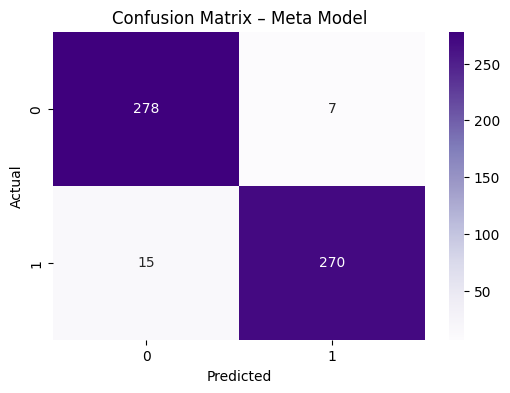

In [ ]:
# CONFUSION MATRIX – META MODEL

from sklearn.metrics import confusion_matrix
import seaborn as sns

meta_pred_class = (meta_win_prob >= 0.5).astype(int)
cm_meta = confusion_matrix(y_clf_test, meta_pred_class)

plt.figure(figsize=(6,4))
sns.heatmap(cm_meta, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Meta Model")
plt.show()
